In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
sys.path.append("/export/raid1/home/styvesg/code/")

import nsd_gnet8x.src.numpy_utility as pnu
from nsd_gnet8x.src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from nsd_gnet8x.src.config import *

%matplotlib inline

In [7]:
from src.geometry import expand_geometry
from src.utility import *
from src.plots import *

In [2]:
input_dir = "../nsd_gnet8x/output/multisubject/gnet8j64t192_mpf_general_Jan-25-2023_1316/"
output_dir = root_dir + 'output/'

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"

In [3]:
def reorganize_err_dict(v1dict):
    '''
    reorganize fewshot accuracy files that were save as ['err'][#subject/#sample][#roi/#layer] to [#subject/#sample]['err'][#roi/#layer] dictionary structure
    '''
    v2dict = {}
    for s in v1dict['err'].keys():
        v2dict[s] = {'err': {}, 'std': {}}
        for r in v1dict['err'][s].keys():
            v2dict[s]['err'][r] = v1dict['err'][s][r]
            v2dict[s]['std'][r] = v1dict['std'][s][r]
    return v2dict

# Reload nsd predictions and masks

In [4]:
data_set = h5py.File(input_dir + 'nsd_prediction_all.h5py', 'r') # nsd_prediction_all.h5py
nsd_stim_pred_dict = embed_dict({s: np.copy(d) for s,d in data_set.items()})
data_set.close()
print (nsd_stim_pred_dict.keys())

dict_keys(['brain_nii_shape', 'pred', 'val_cc', 'voxel_index', 'voxel_mask', 'voxel_roi'])


## Voxel masks

In [9]:
from nsd_gnet8x.src.file_utility import load_mask_from_nii, view_data
from nsd_gnet8x.src.roi import roi_map, iterate_roi

group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'all', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], np.arange(1, 24), [24,25,0]]

voxel_index = nsd_stim_pred_dict['voxel_index']
voxel_roi = nsd_stim_pred_dict['voxel_roi']
voxel_mask = nsd_stim_pred_dict['voxel_mask']

## ROI order

In [11]:
subjects = [1,2,3,4,5,6,7,8]
plot_roi = ['V1', 'V2', 'V3', 'hV4', 'MST', 'V3ab', 'MT', 'PHC', 'VO', 'LO', 'IPS']

subj_cmap = {'%s'%s: cm.get_cmap('rainbow', len(subjects)+1)(k+1) for k,s in enumerate(subjects)}
roi_cmap = {roi: cm.get_cmap('rainbow', len(plot_roi))(k) for k,roi in enumerate(plot_roi)}

### Voxel counts

In [10]:
roi_min_count = {roi: np.inf for roi in group_names}
for s in subjects:
    for roi_mask, roi_name in iterate_roi(group, voxel_roi['%s'%s], roi_map, group_name=group_names):
        N = np.sum(roi_mask)
        if roi_min_count[roi_name]>N:
            roi_min_count[roi_name]=N
print (roi_min_count)

{'V1': 1509, 'V2': 1321, 'V3': 1183, 'hV4': 456, 'V3ab': 680, 'LO': 340, 'IPS': 1463, 'VO': 431, 'PHC': 313, 'MT': 269, 'MST': 35, 'all': 8960, 'other': 202}


---
# Prediction for ImageNet manifolds
## Calculate hierarchical distance form wordnet IDs.

In [33]:
from torchvision import datasets, transforms

imagenet_root = root_dir + "../../data/imagenet/"

data_transform = transforms.Compose([
            transforms.Resize(227), # smallest dimension will be resized to that size
            transforms.CenterCrop((227, 227)), # crop the edges of non-square images
            transforms.ToTensor(), # this automatically convert from uint8 to float in range [0,1]
        ])

inet_val = datasets.ImageNet(imagenet_root, 'val', transform=data_transform)
label_map = inet_val.classes
wnids_map = inet_val.wnids

In [34]:
import nltk
#nltk.download()
#download identifier: wordnet, omw-1.4

from nltk.corpus import wordnet as wn

wnsynset = []
for l in wnids_map:
    wnsynset += [  wn.synset_from_pos_and_offset(l[0], int(l[1:])), ]
    
ND_mat = np.zeros(shape=(len(label_map), len(label_map)))
for i,wi in enumerate(wnsynset):
    for j,wj in enumerate(wnsynset):
        ND_mat[i,j] = wi.path_similarity(wj)
D_mat = ND_mat**(-1) - 1

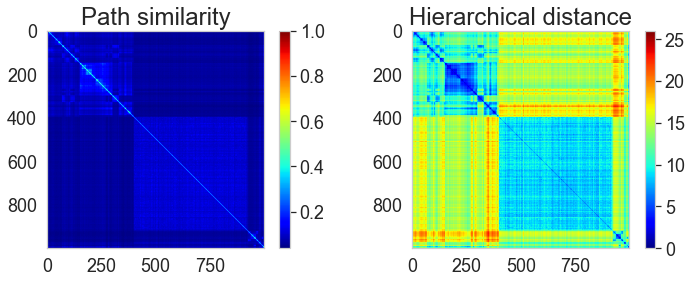

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Path similarity')
plt.imshow(ND_mat, cmap='jet')
plt.colorbar()
plt.grid(False)
plt.subplot(1,2,2)
plt.title('Hierarchical distance')
plt.imshow(D_mat, cmap='jet')
plt.colorbar()
plt.grid(False)

## Load ImageNet 5-shot error pattern and geometric SNR

In [29]:
geom_set = h5py.File(input_dir + 'imagenet_manifold_5shot_err_all.h5py', 'r')
imagenet_nsdpred_5shot_dict = embed_dict({k:np.copy(v) for k,v in geom_set.items()})
geom_set.close()

imagenet_nsdpred_5shot_dict = reorganize_err_dict(imagenet_nsdpred_5shot_dict)

In [30]:
imagenet_nsdpred_geom_data = {}
for s in subjects:
    geom_set = h5py.File(input_dir + 'imagenet_manifold_subj%02d_SNR.h5py'%s, 'r')
    imagenet_nsdpred_geom_data['%s'%s] = embed_dict({k:np.copy(v) for k,v in geom_set.items()})
    geom_set.close()
    
expand_geometry(imagenet_nsdpred_geom_data, ['%s'%s for s in subjects])

## Imagespace ImageNet

In [31]:
net_dir = '../nsd_manifold/output/'

net_set = h5py.File(net_dir + 'imagenet_imagespace_manifold_sample_1_SNR.h5py', 'r')
imagenet_imagespace_geom_data = {'0': embed_dict({k:np.copy(v) for k,v in net_set.items()})}
print (imagenet_imagespace_geom_data['0'].keys())
net_set.close()

expand_geometry(imagenet_imagespace_geom_data, ['0'])

dict_keys(['Bias', 'Ds', 'Nsa', 'Nsb', 'Nss', 'P', 'SNR', 'Sign', 'm'])


# ImageNet summary plots

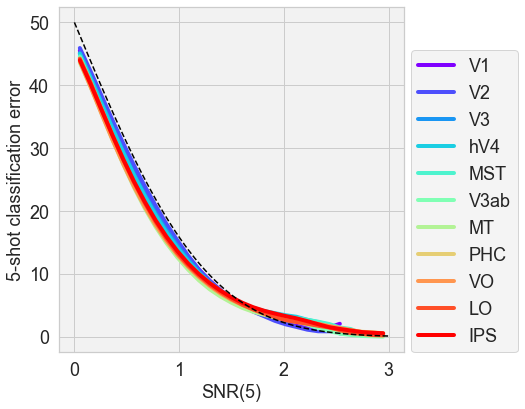

In [212]:
from scipy.stats import binned_statistic
from nsd_manifold.src.geometry import H

fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3)
for k,roi in enumerate(plot_roi):
    X, Y = [], []
    for s in subjects: 
        X += [offdiagonal(imagenet_nsdpred_geom_data['%s'%s]['SNR'][roi]),]
        Y += [offdiagonal(imagenet_nsdpred_5shot_dict['%s'%s]['err'][roi])*100,]
    X = np.array(X).flatten()
    Y = np.array(Y).flatten()
    
    bin_means, bin_edges, binnumber = binned_statistic(X, Y, statistic=np.nanmean, bins=np.linspace(0,3,30))
    bin_stds, bin_edges, binnumber = binned_statistic(X, Y, statistic=np.nanstd, bins=np.linspace(0,3,30))
    X = (bin_edges[1:]+bin_edges[:-1])/2
    #plt.fill_between(X, bin_means-bin_stds, bin_means+bin_stds, color=roi_cmap[k], alpha=.2)
    plt.plot(X, bin_means, marker='None', lw=4, color=roi_cmap[roi], label=roi)   
    
x = np.linspace(0.,3.,100)
plt.plot(x, H(x), color='k', linestyle='dashed')
plt.xlabel('SNR(5)')
plt.ylabel('5-shot classification error')
plt.legend(loc=(1.02, 0.0))

In [ ]:
filename = output_dir + "theory_validation%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

(0.0, 28.0)

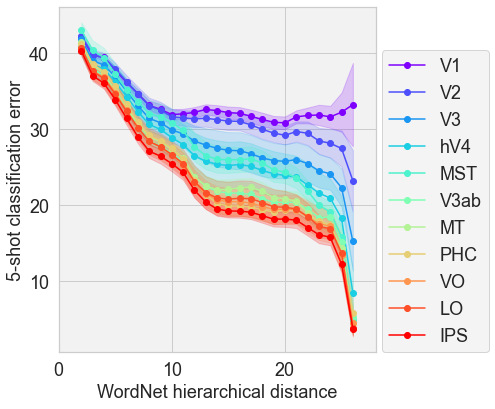

In [216]:
from scipy.stats import binned_statistic

fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.75, top=.95, wspace=0.3, hspace=0.3) 
for k,roi in enumerate(plot_roi):
    Y = []
    for s in subjects:
        x = offdiagonal(D_mat)
        y = offdiagonal(imagenet_nsdpred_5shot_dict['%s'%s]['err'][roi])*100
        bin_means, bin_edges, binnumber = binned_statistic(x, y, statistic='mean', bins=np.arange(0,30))
        Y += [bin_means,]
    Y = np.array(Y)
    subj_means = np.mean(Y, axis=0)
    subj_stds  = np.std(Y, axis=0) 
    plt.fill_between(bin_edges[:-1], subj_means-subj_stds, subj_means+subj_stds, color=roi_cmap[roi], alpha=.2)
    plt.plot(bin_edges[:-1], subj_means, marker='o', color=roi_cmap[roi], label=roi)   
plt.xlabel('WordNet hierarchical distance')
plt.ylabel('5-shot classification error')
plt.legend(loc=(1.02, 0.0))
plt.xlim([0, 28])

In [ ]:
filename = output_dir + "5-shot-accuracy_v_wordnet_distance%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

In [217]:
roi_subj_means, roi_subj_stds = [],[]
for k,roi in enumerate(plot_roi):
    Y = []
    for s in subjects:
        x = offdiagonal(D_mat)
        y = offdiagonal(imagenet_nsdpred_5shot_dict['%s'%s]['err'][roi])*100
        bin_means, bin_edges, binnumber = binned_statistic(x, y, statistic='mean', bins=[0, 6, 12, 18, 24, 30])
        Y += [bin_means,]
    Y = np.array(Y)
    subj_means = np.mean(Y, axis=0)
    subj_stds  = np.std(Y, axis=0) 
    roi_subj_means += [subj_means,]
    roi_subj_stds  += [subj_stds,]

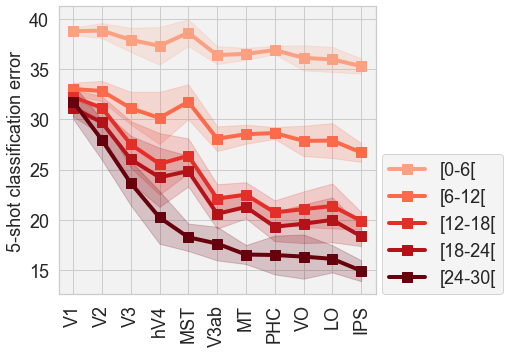

In [218]:
range_cmap = [cm.get_cmap('Reds', len(roi_subj_means[0])+2)(k+2) for k in range(len(roi_subj_means[0]))]

fig=plt.figure(figsize=(8,5))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.75, top=.95, wspace=0.3, hspace=0.3) 
Y_avg = np.zeros(len(plot_roi))
for k, (v,e,l) in enumerate(zip(np.array(roi_subj_means).T, np.array(roi_subj_stds).T, \
                                ['[0-6[', '[6-12[', '[12-18[', '[18-24[', '[24-30['])):
    plt.plot(np.arange(len(plot_roi)), v)
    plt.fill_between(np.arange(len(plot_roi)), v-e, v+e, color=range_cmap[k], alpha=.2)
    plt.plot(np.arange(len(plot_roi)), v, marker='s', ms=10, lw=4, color=range_cmap[k], label=l)  
_=plt.gca().set_xticks(np.arange(len(plot_roi)))
_=plt.gca().set_xticklabels(plot_roi, rotation=90)
plt.ylabel('5-shot classification error')
plt.legend(loc=(1.02, 0.))

In [ ]:
filename = output_dir + "m-shot_accuracy_vs_roi_per_wordnet_distance%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

## Similarity to hierarchical distance and symmetry of 5-shot error

In [220]:
hierarchical_d_to_5shot_err_similarity, symmetry_of_5shot = {}, {}
for s in subjects:
    hierarchical_d_to_5shot_err_similarity[s], symmetry_of_5shot[s] = {}, {}
    for r,e in imagenet_nsdpred_5shot_dict['%s'%s]['err'].items():
        success = set_diagonal_value(1. - e, 0)
        hierarchical_d_to_5shot_err_similarity[s][r] = corrmat(D_mat, success)
        symmetry_of_5shot[s][r] = symmetry_score(success)

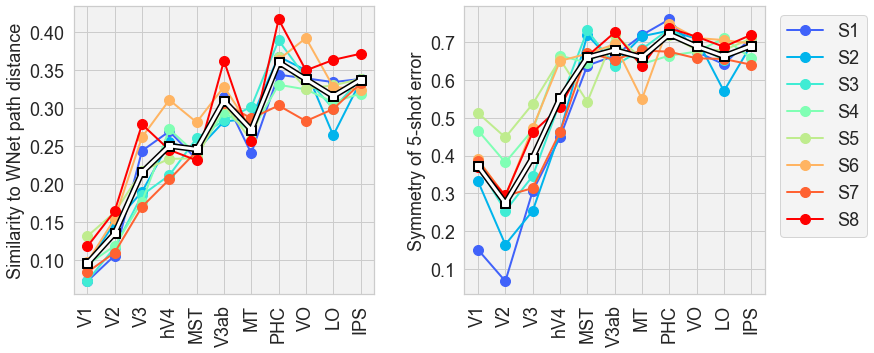

In [226]:
fig=plt.figure(figsize=(16,5))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3) 
plt.subplot(1,2,1)
Y_avg = np.zeros(len(plot_roi))
for s,v in hierarchical_d_to_5shot_err_similarity.items():
    Y = [v[r] for r in plot_roi]
    Y_avg += np.array(Y)
    plt.plot(Y, color=subj_cmap['%s'%s], lw=2, marker='o', ms=10, label='S%s'%s)
plt.plot(Y_avg/len(subjects), color='k', lw=6, marker='s', ms=10)
plt.plot(Y_avg/len(subjects), color='w', lw=3, marker='s', ms=6)
_=plt.gca().set_xticks(np.arange(len(plot_roi)))
_=plt.gca().set_xticklabels(plot_roi, rotation=90)
plt.ylabel('Similarity to WNet path distance')
###
plt.subplot(1,2,2)
Y_avg = np.zeros(len(plot_roi))
for s,v in symmetry_of_5shot.items():
    Y = [v[r] for r in plot_roi]
    Y_avg += np.array(Y)
    plt.plot(Y, color=subj_cmap['%s'%s], lw=2, marker='o', ms=10, label='S%s'%s)
plt.plot(Y_avg/len(subjects), color='k', lw=6, marker='s', ms=10)
plt.plot(Y_avg/len(subjects), color='w', lw=3, marker='s', ms=6)
_=plt.gca().set_xticks(np.arange(len(plot_roi)))
_=plt.gca().set_xticklabels(plot_roi, rotation=90)
plt.ylabel('Symmetry of 5-shot error')
plt.legend(loc=(1.05, 0.2))

In [ ]:
filename = output_dir + "similarity_and_symmetry_5shot_err_all%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

---
# Prediction and data for NSD manifolds

### Pred

In [12]:
data_set = h5py.File(input_dir + 'nsdpred_zmanifold_5shot_err_all_v3.h5py', 'r')
nsdpred_5shot_dict = embed_dict({s: np.copy(d) for s,d in data_set.items()})
print (nsdpred_5shot_dict.keys())
data_set.close()

nsdpred_5shot_dict = reorganize_err_dict(nsdpred_5shot_dict)

dict_keys(['err', 'std'])


In [13]:
data_set = h5py.File(input_dir + 'nsdpred_zmanifold_SNR_all_v3.h5py', 'r')
nsdpred_geom_dict = embed_dict({s: np.copy(d) for s,d in data_set.items()})
print (nsdpred_geom_dict.keys())
data_set.close()

expand_geometry(nsdpred_geom_dict, ['%s'%s for s in subjects])

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', 'K', 'P', 'V', 'm'])


### Data

In [14]:
data_set = h5py.File(input_dir + 'nsddata_zmanifold_SNR_all_v3.h5py', 'r')
nsddata_geom_dict = embed_dict({s: np.copy(d) for s,d in data_set.items()})
print (nsddata_geom_dict.keys())
data_set.close()

expand_geometry(nsddata_geom_dict, ['%s'%s for s in subjects]) 

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', 'K', 'P', 'V', 'm'])


## Imagespace

In [15]:
net_dir = '../nsd_manifold/output/'

net_set = h5py.File(net_dir + 'imagespace_zmanifold_SNR_v2.h5py', 'r')
imagespace_geom_dict = embed_dict({k:np.copy(v) for k,v in net_set.items()})
print (imagespace_geom_dict.keys())
net_set.close()

ssamples = ['%d'%k for k in np.arange(9)]
expand_geometry(imagespace_geom_dict, ssamples)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', 'P', 'm'])


## Alexnet

In [16]:
net_dir = '../nsd_manifold/output/'

net_set = h5py.File(net_dir + 'msalexnet_zmanifold_SNR_v2.h5py', 'r')
alexnet_geom_dict = embed_dict({k:np.copy(v) for k,v in net_set.items()})
print (alexnet_geom_dict.keys())
net_set.close()

ssamples = ['%d'%k for k in np.arange(9)]
expand_geometry(alexnet_geom_dict, ssamples)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', 'P', 'm'])


## Random Alexnet

In [17]:
net_dir = '../nsd_manifold/output/'

#net_set = h5py.File(net_dir + 'ralexnet_zmanifold_all_SNR.h5py', 'r')
net_set = h5py.File(net_dir + 'old_msralexnet_zmanifold_all_SNR.h5py', 'r')
ralexnet_geom_dict = embed_dict({k:np.copy(v) for k,v in net_set.items()})
print (ralexnet_geom_dict.keys())
net_set.close()

expand_geometry(ralexnet_geom_dict, ssamples)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', 'P', 'm'])


## Resnet50

In [18]:
net_dir = '../nsd_manifold/output/'

net_set = h5py.File(net_dir + 'msresnet50_zmanifold_SNR_v2.h5py', 'r')
resnet50_geom_dict = embed_dict({k:np.copy(v) for k,v in net_set.items()})
print (resnet50_geom_dict.keys())
net_set.close()

expand_geometry(resnet50_geom_dict, ssamples)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', 'P', 'm'])


## Random Resnet50

In [19]:
net_dir = '../nsd_manifold/output/'

net_set = h5py.File(net_dir + 'msresnet50-R_shuffle_zmanifold_all_SNR.h5py', 'r')
resnet50R_geom_dict = embed_dict({k:np.copy(v) for k,v in net_set.items()})
print (resnet50R_geom_dict.keys())
net_set.close()

expand_geometry(resnet50R_geom_dict, ssamples)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', 'P', 'm'])


In [20]:
net_dicts = {'alexnet': alexnet_geom_dict, 
             'alexnet-R': ralexnet_geom_dict,
             'resnet50': resnet50_geom_dict, 
             'resnet50-R': resnet50R_geom_dict,
             'imagespace': imagespace_geom_dict
            }

net_cmap = {'alexnet': (0, .6, .1, 1), 
            'alexnet-R': (.2, .8, .3, 1), 
            'resnet50': (.4, 0, .4, 1),
            'resnet50-R': (.6, .2, .6, 1),
            'imagespace': 'k'
           }

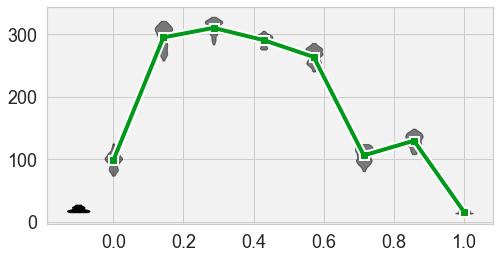

In [23]:
plt.figure(figsize=(8,4))
_, sa, samin, samax = geom_sample_average(net_dicts['imagespace'], 'DR', ['0'], {'0': 'k'}, \
                                       ['0'], percentile_cutoff=5, pos_offset=-.1, width_mult=.1, aggregate_samples=False)

x, sa, samin, samax = geom_sample_average(net_dicts['alexnet'], 'DR', ['%s'%s for s in range(9)], {'%s'%s: cm.get_cmap('rainbow', 9)(s) for s in range(9)}, \
                                       plot_roi=['%s'%l for l in range(8)], percentile_cutoff=5, pos_lims=[0, 1], aggregate_samples=True)

ya = np.mean(sa, axis=0)
ys = np.std(sa, axis=0)
_=plt.errorbar(x, y=ya, yerr=ys, marker='s', ms=10, color='w', lw=8, zorder=800) 
_=plt.errorbar(x, y=ya, yerr=ys, marker='s', ms=6, color=net_cmap['alexnet'], lw=4, label='alexnet', zorder=999) 

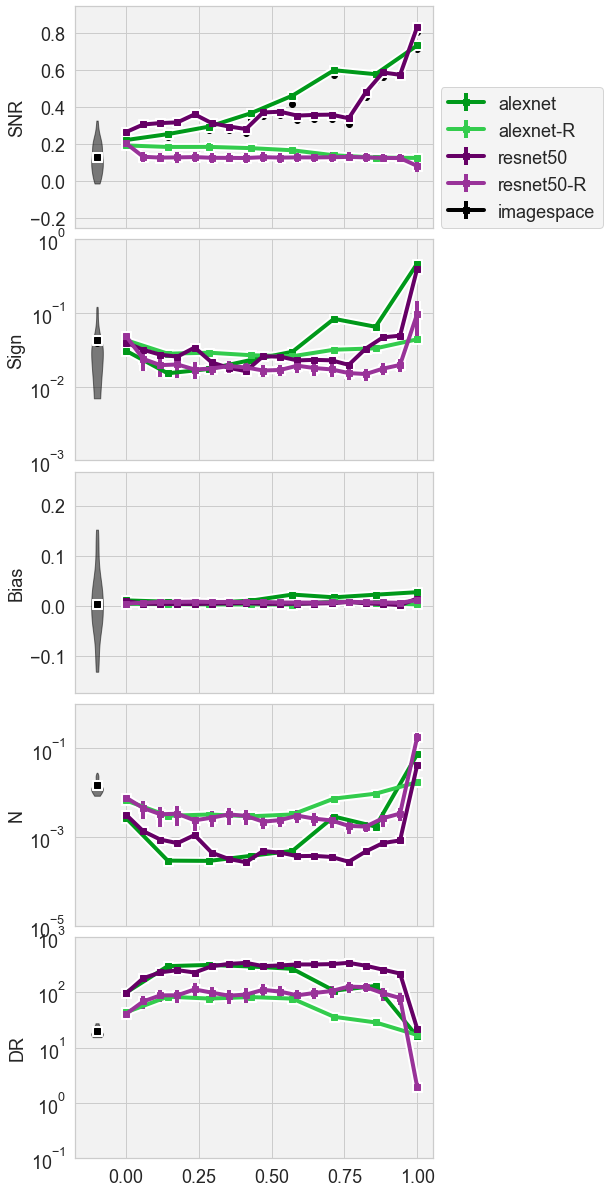

In [24]:
net_sample_names = ['%s'%s for s in range(9)]
net_sample_colors= {'%s'%s: cm.get_cmap('rainbow', 9)(s) for s in range(9)}

fig = plt.figure(figsize=(6, 20))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.15, hspace=0.05)
for k,name in enumerate(['SNR', 'Sign', 'Bias', 'N', 'DR']):
    plt.subplot(5,1,k+1)
    ####
    gYmin, gYmax = np.inf, -np.inf
    for i,(net,dd) in enumerate(net_dicts.items()):

        if net=='imagespace':
            x, sa, samin, samax = geom_sample_average(net_dicts[net], name, ['0'], {'0': 'k'}, \
                                       ['0'], percentile_cutoff=5, pos_offset=-.1, width_mult=.1, aggregate_samples=True)  
            gYmin, gYmax = min(samin, gYmin), max(samax, gYmax)              
            ya, ys = np.mean(sa, axis=0), np.std(sa, axis=0)
            _=plt.errorbar(x, y=ya, yerr=ys, marker='s', ms=10, color='w', lw=8, zorder=800) 
            _=plt.errorbar(x, y=ya, yerr=ys, marker='s', ms=6, color=net_cmap[net], lw=4, label=net, zorder=999) 
        else:
            layers = ['%s'%l for l in range(len(net_dicts[net]['0']['SNR']))]
            x, sa, samin, samax = geom_sample_average(net_dicts[net], name, net_sample_names, net_sample_colors, \
                                       plot_roi=layers, percentile_cutoff=5, pos_lims=[0, 1], plot_violins=False, aggregate_samples=True) 
            gYmin, gYmax = min(samin, gYmin), max(samax, gYmax)           
            ya, ys = np.mean(sa, axis=0), np.std(sa, axis=0)
            _=plt.errorbar(x, y=ya, yerr=ys, marker='s', ms=10, color='w', lw=8, zorder=800) 
            _=plt.errorbar(x, y=ya, yerr=ys, marker='s', ms=6, color=net_cmap[net], lw=4, label=net, zorder=999) 
    ####
    gYmin, gYmax = .5*gYmin, .5*gYmax
    if name!='Bias' and name!='SNR':
        if gYmin<=0:
            gYmin = gYmax / 1e2
        plt.ylim([round10down(gYmin), round10up(gYmax)])
        plt.yscale('log')
    else:
        plt.ylim([gYmin, gYmax])        
    if k>=4:
        plt.gca().set_xticks([0, .25, .5, .75, 1.])
    else:
        plt.gca().set_xticklabels([])
    if name=='SNR':
        plt.legend(loc=(1.02, 0))
    plt.ylabel(name)

In [370]:
filename = output_dir + "different_variant_geom_flow%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

## Re-order according to pred SNR(5)

['V1', 'V2', 'MST', 'MT', 'hV4', 'V3', 'PHC', 'VO', 'V3ab', 'LO', 'IPS']


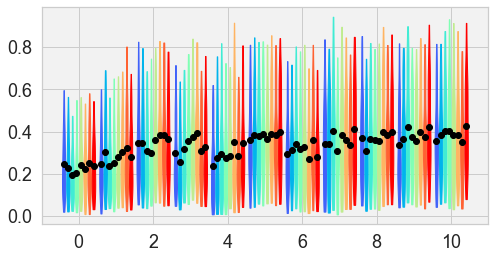

In [25]:
plt.figure(figsize=(8,4))
x, sa, samin, samax = geom_sample_average(nsdpred_geom_dict, 'SNR', ['%s'%s for s in subjects], {'%s'%s: cm.get_cmap('rainbow', 9)(s) for s in subjects}, \
                                       plot_roi=plot_roi, percentile_cutoff=5, aggregate_samples=False)
## Replaces: sa, gYmin, gYmax = braingeom_sample_average(nsdpred_geom_dict, 'SNR', subjects, plot_roi, percentile_cutoff=5) 

plot_roi_re = [plot_roi[i] for i in np.argsort(np.mean(sa, axis=0))]
print (plot_roi_re)

# Pred Characterization

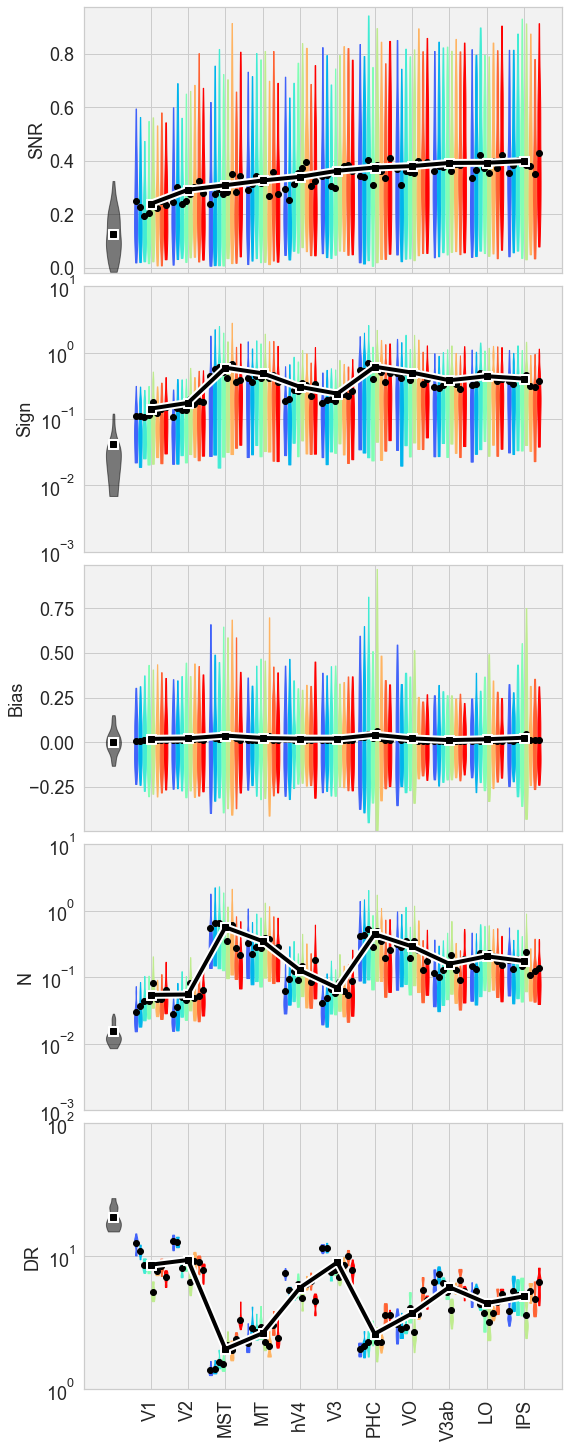

In [200]:
metric_average = {}
fig = plt.figure(figsize=(8, 24))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.15, hspace=0.05)
for k,name in enumerate(['SNR', 'Sign', 'Bias', 'N', 'DR']):
    plt.subplot(5,1,k+1)
    ####
    x, sa, gYmin, gYmax = geom_sample_average(nsdpred_geom_dict, name, ['%s'%s for s in subjects], {'%s'%s: cm.get_cmap('rainbow', 9)(s) for s in subjects}, \
        plot_roi=plot_roi_re, percentile_cutoff=5, aggregate_samples=False)
    #sa, gYmin, gYmax = braingeom_sample_average(nsdpred_geom_dict, name, subjects, plot_roi_re, percentile_cutoff=5)  
    metric_average[name] = sa
    
    _=plt.plot(x, np.mean(sa, axis=0), marker='s', ms=10, color='w', lw=8)
    _=plt.plot(x, np.mean(sa, axis=0), marker='s', ms=6, color='k', lw=4)    
    ##
    x, sa, samin, samax = geom_sample_average(net_dicts[net], name, ['0'], {'0': 'k'}, \
        ['0'], percentile_cutoff=5, pos_offset=-1, width_mult=1, aggregate_samples=True)  
    gYmin, gYmax = min(samin, gYmin), max(samax, gYmax)  
    ya, ys = np.mean(sa, axis=0), np.std(sa, axis=0)
    _=plt.errorbar(x, y=ya, yerr=ys, marker='s', ms=10, color='w', lw=8, zorder=800) 
    _=plt.errorbar(x, y=ya, yerr=ys, marker='s', ms=6, color=net_cmap[net], lw=4, label=net, zorder=999) 
    
    plt.gca().set_xticks(np.arange(len(plot_roi_re)))
    if k>=4:
        plt.gca().set_xticklabels(plot_roi_re, rotation=90)
    else:
        plt.gca().set_xticklabels([])
    if name!='Bias' and name!='SNR':
        ymin, ymax = round10down(gYmin), round10up(gYmax)
        plt.ylim([ymin, ymax])
        plt.yscale('log')
    else:
        plt.ylim([gYmin, gYmax])
    plt.ylabel(name)

In [53]:
filename = output_dir + "nsdpred_geometry_nsdsupercat_per_ROI_v3%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

---
# Trajectory in geometry space

In the following, we will calculate the principal direction of variation in a space of the geometric characteristic of pairs of concept manifolds. 

In [26]:
def logN_fn_logS(X, alpha, gamma):
    return np.array([alpha])@X + gamma

def logN_fn_logS_and_logD(X, alpha, beta, gamma):
    return np.array([alpha, beta])@X + gamma

def predict_N(N, S, D):
    from scipy.optimize import curve_fit
    
    X = np.array([S.flatten()])
    Y = N.flatten()
    popt, pcov = curve_fit(logN_fn_logS, X, Y)
    perr = np.sqrt(np.diag(pcov))
    print (popt, perr)

    Yp = logN_fn_logS(X, *popt)
    print ('N(S): R2 = ', np.corrcoef(Y, Yp)[0,1]**2)
    ###
    X = np.array([S.flatten(),
                  D.flatten()])
    popt, pcov = curve_fit(logN_fn_logS_and_logD, X, Y)
    perr = np.sqrt(np.diag(pcov))
    print (popt, perr)

    Yp = logN_fn_logS_and_logD(X, *popt)
    print ('N(S,D): R2 = ', np.corrcoef(Y, Yp)[0,1]**2)
    return Y, Yp, popt

def SNR_fn_logS_and_logD_restricted(x, y, popt):
    X = np.array([x.flatten(), y.flatten()])
    return (.5*10**x / np.sqrt(.2*10**(-y) + 10**logN_fn_logS_and_logD(X, *popt).reshape(x.shape)))

In [27]:
def log10_transform(x):
    return np.log10(x)
def log10_transform_mean(x, axis=None):
    if axis is not None:
        #return np.mean(x, axis=axis)
        return np.log10(np.mean(10**x, axis=axis))
    else:
        #return np.mean(x)
        return np.log10(np.mean(10**x))

def get_geometric_space_array(geom_data, subjects, plot_roi, space, transform, mask=None):
    geom_traj = []
    for name in ['SNR',] + space:
        layers = []
        for r in plot_roi:
            for s in subjects: # imagenet_nsdpred_geom_data
                if mask is None: 
                    layers += [offdiagonal(geom_data['%s'%s][name][r]),]
                else:
                    layers += [invalid_to_num((geom_data['%s'%s][name][r].flatten())[mask], np.mean),]
        geom_traj += [np.array(layers),]    
    geom_traj = np.array(geom_traj)
    SNR_traj = geom_traj[0].reshape(len(plot_roi), len(subjects), -1)
    geom_traj = transform( geom_traj[1:].reshape((len(space), len(plot_roi), len(subjects), -1)) )
    return SNR_traj, geom_traj

In [36]:
space = ['Sign', 'N', 'DR', 'DL']
#space = ['Sign', 'Nsa', 'Nsb', 'Nss', 'DR', 'DL']

SNR_traj, geom_traj = get_geometric_space_array(imagenet_nsdpred_geom_data, subjects, plot_roi, space, log10_transform, mask=D_mat.flatten()>=24)
print (geom_traj.shape)

(4, 11, 8, 322)


In [37]:
Y, Yp, popt = predict_N(geom_traj[np.argmax(np.array(space)=='N')], \
                        geom_traj[np.argmax(np.array(space)=='Sign')], \
                        geom_traj[np.argmax(np.array(space)=='DR')])

[ 1.05673686 -0.36748497] [0.0021763  0.00124319]
N(S): R2 =  0.8927184865231865
[ 0.94443449 -0.68508585  0.03668684] [0.00177233 0.00448919 0.00280401]
N(S,D): R2 =  0.9411181818277549


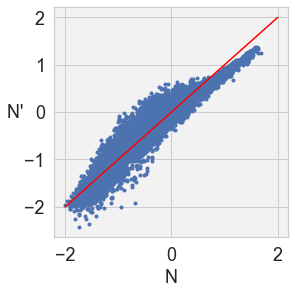

In [38]:
fig=plt.figure(figsize=(5,4))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.85, top=.95, wspace=0.65, hspace=0.3)
_=plt.plot(Y, Yp, linestyle='None', marker='.')
_=plt.plot([-2, 2], [-2, 2], color='r')
_=plt.xlabel('N')
_=plt.ylabel('N\'  ', rotation=0)

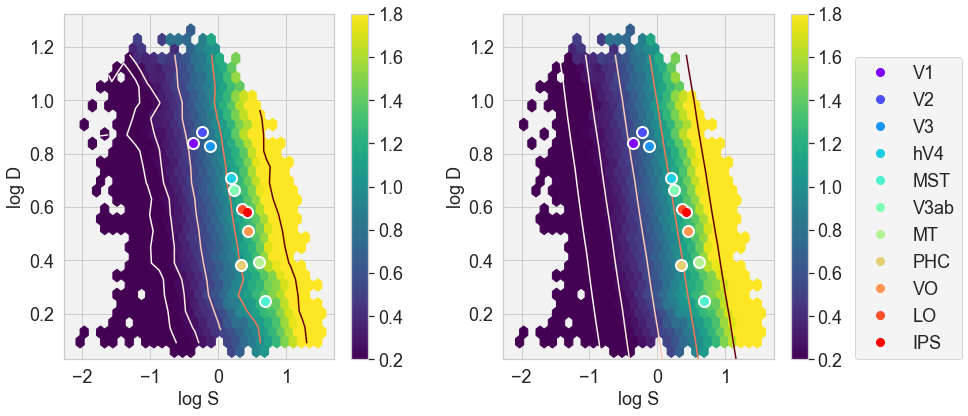

In [388]:
X = geom_traj[np.argmax(np.array(space)=='Sign')].reshape((geom_traj.shape[1], -1))
Y = geom_traj[np.argmax(np.array(space)=='DR')].reshape((geom_traj.shape[1], -1))
Z = SNR_traj.reshape((SNR_traj.shape[0], -1))

fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3)
plt.subplot(1,2,1)
plt.hexbin(X.flatten(), Y.flatten(), C=Z.flatten(), gridsize=30, cmap='viridis', vmin=.2, vmax=1.8)
_=plt.colorbar()
from scipy.stats import binned_statistic_2d
ba, xe, ye, bn = binned_statistic_2d(x=X.flatten(), y=Y.flatten(), values=Z.flatten(),\
    statistic='mean', bins=20, range=[[-2., 1.5], [0, 1.2]], expand_binnumbers=False)
xr, yr = (xe[1:]+xe[:-1])/2, (ye[1:]+ye[:-1])/2, 
Xr, Yr = np.meshgrid(xr, yr)
plt.contour(Xr, Yr, ba.T, levels=[0.125, .25, .5, 1., 2], cmap='Reds')

for k,(x,y,z,t) in enumerate(zip(X, Y, Z, plot_roi)):
    plt.plot(log10_transform_mean(x), space_transform_mean(y), marker='o', color='w', ms=12,zorder=999)
    plt.plot(log10_transform_mean(x), space_transform_mean(y), marker='o', color=roi_cmap[t], \
             linestyle='None', ms=8, zorder=1000, label=t)
_=plt.xlabel('log S')
_=plt.ylabel('log D')
###
plt.subplot(1,2,2)
plt.hexbin(X.flatten(), Y.flatten(), C=Z.flatten(), gridsize=30, cmap='viridis', vmin=.2, vmax=1.8)
_=plt.colorbar()
from scipy.stats import binned_statistic_2d
ba, xe, ye, bn = binned_statistic_2d(x=X.flatten(), y=Y.flatten(), values=Z.flatten(),\
    statistic='mean', bins=20, range=[[-2., 1.5], [0, 1.2]], expand_binnumbers=False)
xr, yr = (xe[1:]+xe[:-1])/2, (ye[1:]+ye[:-1])/2, 
Xr, Yr = np.meshgrid(xr, yr)

for k,(x,y,z,t) in enumerate(zip(X, Y, Z, plot_roi)):
    plt.plot(log10_transform_mean(x), log10_transform_mean(y), marker='o', color='w', ms=12,zorder=999)
    plt.plot(log10_transform_mean(x), log10_transform_mean(y), marker='o', color=roi_cmap[t], \
             linestyle='None', ms=8, zorder=1000, label=t)
Zr = SNR_fn_logS_and_logD_restricted(Xr, Yr, popt)
plt.contour(Xr, Yr, Zr, levels=[0.125, .25, .5, 1., 2], cmap='Reds')
_=plt.xlabel('log S')
_=plt.ylabel('log D')
_=plt.legend(loc=(1.3, 0))

In [1537]:
filename = output_dir + "imagenet_hD24_geom_SNR_color_D_vs_S_details%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

# Project model prediction and network representation on PC directions
## GNet8j-pred

In [39]:
space = ['Sign', 'N', 'DR', 'DL']
#space = ['Sign', 'Nsa', 'Nsb', 'Nss', 'DR', 'DL']

nsdpred_SNR_traj, nsdpred_geom_traj = get_geometric_space_array(nsdpred_geom_dict, subjects, plot_roi, space, log10_transform, mask=None)
print (nsdpred_geom_traj.shape)

(4, 11, 8, 132)


In [40]:
Y, Yp, popt =  predict_N(nsdpred_geom_traj[np.argmax(np.array(space)=='N')], \
                        nsdpred_geom_traj[np.argmax(np.array(space)=='Sign')], \
                        nsdpred_geom_traj[np.argmax(np.array(space)=='DR')])

[ 0.74550379 -0.40919396] [0.00478677 0.00396724]
N(S): R2 =  0.6762177947913709
[ 0.63290358 -0.88425136  0.10279128] [0.00274899 0.00548099 0.00386361]
N(S,D): R2 =  0.9001056704223666


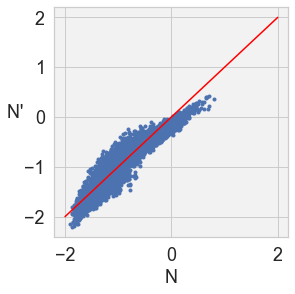

In [41]:
fig=plt.figure(figsize=(5,4))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.85, top=.95, wspace=0.65, hspace=0.3)
_=plt.plot(Y, Yp, linestyle='None', marker='.')
_=plt.plot([-2, 2], [-2, 2], color='r')
_=plt.xlabel('N')
_=plt.ylabel('N\'  ', rotation=0)
#_=plt.xlim([0, 1])
#_=plt.ylim([0, 1])

In [57]:
from matplotlib.colors import Normalize, LogNorm
SNR_norm = LogNorm(vmin=.125/2, vmax=2., clip=True) #Normalize(vmin=.125/2, vmax=2, clip=True)
SNR_colors = cm.ScalarMappable(norm=SNR_norm, cmap='viridis')
SNR_colors.set_array([])  
SNR_cmap = SNR_colors.get_cmap()

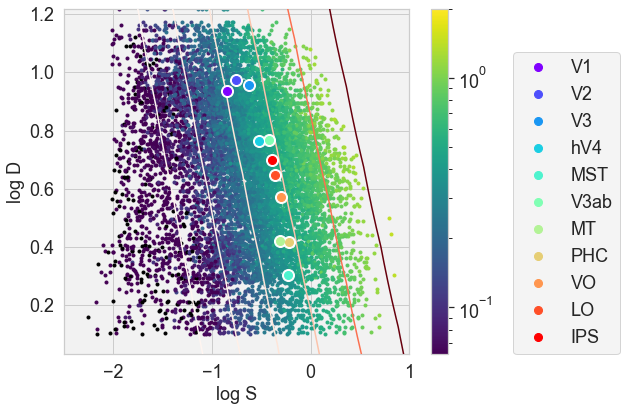

In [286]:
from scipy.stats import binned_statistic_2d

fig=plt.figure(figsize=(10,6))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3)

X = nsdpred_geom_traj[np.argmax(np.array(space)=='Sign')].reshape((nsdpred_geom_traj.shape[1], -1))
Y = nsdpred_geom_traj[np.argmax(np.array(space)=='DR')].reshape((nsdpred_geom_traj.shape[1], -1))
Z = nsdpred_SNR_traj.reshape((nsdpred_SNR_traj.shape[0], -1))

ba, xe, ye, bn = binned_statistic_2d(x=X.flatten(), y=Y.flatten(), values=Z.flatten(),\
    statistic='mean', bins=20, range=[[-2., 1.5], [0, 1.25]], expand_binnumbers=False)
xr, yr = (xe[1:]+xe[:-1])/2, (ye[1:]+ye[:-1])/2, 
Xr, Yr = np.meshgrid(xr, yr)

for k,(x,y,z,t) in enumerate(zip(X, Y, Z, plot_roi)):
    for xi,yi,zi in zip(x,y,z):
        plt.plot(xi, yi, linestyle='None', color=SNR_cmap(SNR_norm(zi)), alpha=1., marker='.')
    plt.plot(log10_transform_mean(x), space_transform_mean(y), marker='o', color='w', ms=12, zorder=999)
    plt.plot(log10_transform_mean(x), space_transform_mean(y), marker='o', color=roi_cmap[t], \
             linestyle='None', ms=8, zorder=1000, label=t)

Zr = SNR_fn_logS_and_logD_restricted(Xr, Yr, popt)
plt.contour(Xr, Yr, Zr, levels=[0.125/2, 0.125, .25, .5, 1., 2], cmap='Reds', zorder=999)
_=plt.xlim([-2.5, 1])
_=plt.colorbar(SNR_colors)
_=plt.xlabel('log S')
_=plt.ylabel('log D')
_=plt.legend(loc=(1.3, 0))

In [671]:
filename = output_dir + "nsdpred_logD_vs_logS_with_color_SNR%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

# Network models

In [42]:
net_dicts = {'alexnet': alexnet_geom_dict, 
             'alexnet-R': ralexnet_geom_dict,
             'resnet50': resnet50_geom_dict, 
             'resnet50-R': resnet50R_geom_dict,
             'imagespace': imagespace_geom_dict
            }

In [43]:
network_SNR_traj, network_geom_traj = {}, {}
for model_name, geom_dict in net_dicts.items():
    print ('--- %s ---'%model_name)
  
    network_SNR_traj[model_name], network_geom_traj[model_name] = \
        get_geometric_space_array(geom_dict, ssamples, ['%d'%l for l in range(len(geom_dict['1']['SNR']))], space, log10_transform, mask=None)
    Y, Yp, popt = predict_N(network_geom_traj[model_name][np.argmax(np.array(space)=='N')], \
                            network_geom_traj[model_name][np.argmax(np.array(space)=='Sign')], \
                            network_geom_traj[model_name][np.argmax(np.array(space)=='DR')])

--- alexnet ---
[ 1.24043658 -1.08738332] [0.00746872 0.0114943 ]
N(S): R2 =  0.7437843292637273
[ 0.37912686 -1.39762395  0.6633693 ] [0.00375675 0.0047548  0.00696896]
N(S,D): R2 =  0.974616572722073
--- alexnet-R ---
[ 0.4823186  -1.51766436] [0.00839833 0.01366949]
N(S): R2 =  0.25767011553234925
[ 0.30705582 -1.00030705 -0.1201857 ] [0.00248376 0.00309337 0.00585159]
N(S,D): R2 =  0.938170583420808
--- resnet50 ---
[ 0.98028979 -1.59473918] [0.0053182  0.00874262]
N(S): R2 =  0.613754710383647
[ 0.34360915 -1.39910489  0.6834139 ] [0.0023377  0.00336725 0.00620362]
N(S,D): R2 =  0.9574368151688737
--- resnet50-R ---
[ 0.80452851 -1.03896533] [0.00714048 0.01319264]
N(S): R2 =  0.3725363790222101
[ 0.37649708 -0.9791813  -0.00463825] [0.0014869  0.0013111  0.00288857]
N(S,D): R2 =  0.9768352146551719
--- imagespace ---
[ 0.35921363 -1.27463097] [0.00763638 0.01188797]
N(S): R2 =  0.6510470375320289
[ 0.32574537 -0.62427598 -0.54043329] [0.0062555  0.02425855 0.03007813]
N(S,D): R2 

## Combine trajectories

In [44]:
traj_dicts = {'nsdpred': nsdpred_geom_traj,
            #'nsddata': nsddata_geom_traj,
            }
traj_dicts.update(network_geom_traj)

SNR_dicts = {'nsdpred': nsdpred_SNR_traj,
            #'nsddata': nsddata_SNR_traj,
            }
SNR_dicts.update(network_SNR_traj)

In [45]:
model_cmap = {'nsdpred': 'b',
            'alexnet': (0, .6, .1, 1), 
            'alexnet-R': (.2, .8, .3, 1), 
            'resnet50': (.4, 0, .4, 1),
            'resnet50-R': (.6, .2, .6, 1),
            'vgg19': (.6, .4, 0., 1),
            'vgg19-R': (.8, .6, 0., 1), 
            'imagespace': 'k'
           }

---

# Combined network and brain SNR plot
## Independent iso-SNR lines

-- nsdpred --
[ 0.74550379 -0.40919396] [0.00478677 0.00396724]
N(S): R2 =  0.6762177947913709
[ 0.63290358 -0.88425136  0.10279128] [0.00274899 0.00548099 0.00386361]
N(S,D): R2 =  0.9001056704223666
-- alexnet --
[ 1.24043658 -1.08738332] [0.00746872 0.0114943 ]
N(S): R2 =  0.7437843292637273
[ 0.37912686 -1.39762395  0.6633693 ] [0.00375675 0.0047548  0.00696896]
N(S,D): R2 =  0.974616572722073
-- alexnet-R --
[ 0.4823186  -1.51766436] [0.00839833 0.01366949]
N(S): R2 =  0.25767011553234925
[ 0.30705582 -1.00030705 -0.1201857 ] [0.00248376 0.00309337 0.00585159]
N(S,D): R2 =  0.938170583420808
-- resnet50 --
[ 0.98028979 -1.59473918] [0.0053182  0.00874262]
N(S): R2 =  0.613754710383647
[ 0.34360915 -1.39910489  0.6834139 ] [0.0023377  0.00336725 0.00620362]
N(S,D): R2 =  0.9574368151688737
-- resnet50-R --
[ 0.80452851 -1.03896533] [0.00714048 0.01319264]
N(S): R2 =  0.3725363790222101
[ 0.37649708 -0.9791813  -0.00463825] [0.0014869  0.0013111  0.00288857]
N(S,D): R2 =  0.97683521

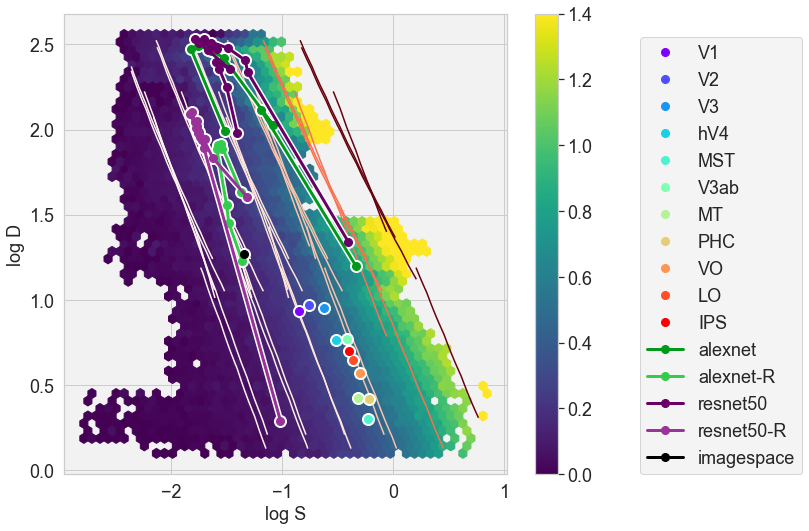

In [47]:
from scipy.stats import binned_statistic_2d

fig=plt.figure(figsize=(14,8))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.75, top=.95, wspace=0.3, hspace=0.3)

Xg, Yg, Zg = [],[],[]
all_N, all_Np, all_popt = [],[],[]
for j,(name,traj,snr) in enumerate(zip_dict(traj_dicts, SNR_dicts)): # model loop

    X = traj[np.argmax(np.array(space)=='Sign')].reshape((traj.shape[1], -1))
    Y = traj[np.argmax(np.array(space)=='DR')].reshape((traj.shape[1], -1))
    Z = snr.reshape((snr.shape[0], -1))
    Xg += [X.flatten(),]
    Yg += [Y.flatten(),]
    Zg += [Z.flatten(),]
    Xmin, Xmax = np.min(X), np.max(X)
    Ymin, Ymax = np.min(Y), np.max(Y)
    ba, xe, ye, bn = binned_statistic_2d(x=X.flatten(), y=Y.flatten(), values=Z.flatten(),\
        statistic='mean', bins=20, range=[[Xmin, Xmax], [Ymin, Ymax]], expand_binnumbers=False)
    xr, yr = (xe[1:]+xe[:-1])/2, (ye[1:]+ye[:-1])/2, 
    Xr, Yr = np.meshgrid(xr, yr)

    if name=='nsdpred':
        for k,(x,y,z,t) in enumerate(zip(X, Y, Z, plot_roi)):
            plt.plot(log10_transform_mean(x), log10_transform_mean(y), marker='o', color='w', ms=12,zorder=999)
            plt.plot(log10_transform_mean(x), log10_transform_mean(y), marker='o', color=roi_cmap[t], \
                 linestyle='None', ms=8, zorder=1000, label=t)
    else:
        plt.plot(log10_transform_mean(X, axis=1), log10_transform_mean(Y, axis=1), marker='o', color='w', ms=12, lw=6, zorder=999)
        plt.plot(log10_transform_mean(X, axis=1), log10_transform_mean(Y, axis=1), marker='o', color=model_cmap[name], \
                 lw=3, ms=8, zorder=1000, label=name)

    print ('-- %s --'%name)
    Y, Yp, popt = predict_N(traj[np.argmax(np.array(space)=='N')], \
                            traj[np.argmax(np.array(space)=='Sign')], \
                            traj[np.argmax(np.array(space)=='DR')])    
    all_N += [Y,]
    all_Np+= [Yp,]
    all_popt += [popt,]
    Zr = SNR_fn_logS_and_logD_restricted(Xr, Yr, popt)
    plt.contour(Xr, Yr, Zr, levels=[0.125/2, 0.125, .25, .5, 1., 2], cmap='Reds', zorder=999)    
    
X = np.concatenate(Xg)
Y = np.concatenate(Yg)
Z = np.concatenate(Zg)
###
_=plt.hexbin(X, Y, C=Z, gridsize=50, cmap='viridis', vmin=0, vmax=1.4, zorder=1)
_=plt.colorbar()
_=plt.xlabel('log S')
_=plt.ylabel('log D')
_=plt.legend(loc=(1.3, 0))

In [462]:
filename = output_dir + "joint_geom_SNR_color_logD_vs_logS_theory_isoline%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

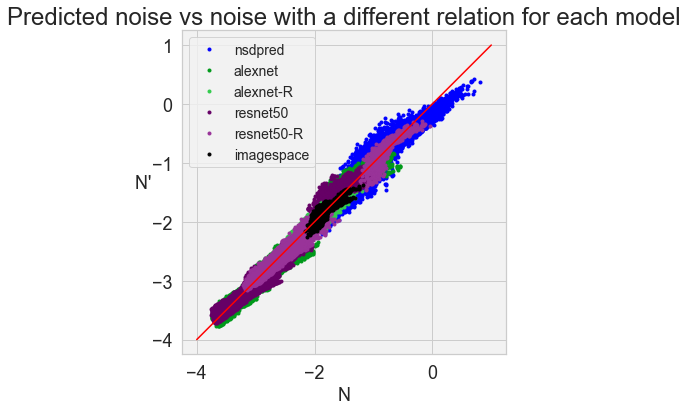

In [48]:
fig=plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.2, bottom=0.2, right=.95, top=.95, wspace=0.35, hspace=0.3)
for j,(Y, Yp, name) in enumerate(zip(all_N, all_Np, traj_dicts.keys())):
    _=plt.plot(Y, Yp, linestyle='None', marker='.', color=model_cmap[name], label=name)
_=plt.plot([-4,1], [-4,1], color='r')
_=plt.xlabel('N')
_=plt.ylabel('N\'  ', rotation=0)
_=plt.legend(loc='upper left', fontsize=14)
_=plt.title("Predicted noise vs noise with a different relation for each model")

## Based on the apparent alignment of the isoline, we can calculate an aggregated estimate for the noise prediction

In [54]:
all_SNR  = np.concatenate([d.flatten() for s,d in SNR_dicts.items()], axis=0 )
all_traj = np.concatenate([d.reshape(len(space), -1) for s,d in traj_dicts.items()], axis=1 )

In [52]:
all_Y, all_Yp, global_popt = predict_N(all_traj[np.argmax(np.array(space)=='N')], \
                        all_traj[np.argmax(np.array(space)=='Sign')], \
                        all_traj[np.argmax(np.array(space)=='DR')])

[ 1.19270903 -0.67063789] [0.00390416 0.00622052]
N(S): R2 =  0.5558361912305984
[ 0.35415144 -1.14639507  0.15951706] [0.00129088 0.00111386 0.00178765]
N(S,D): R2 =  0.9707860641208396


# Final plot

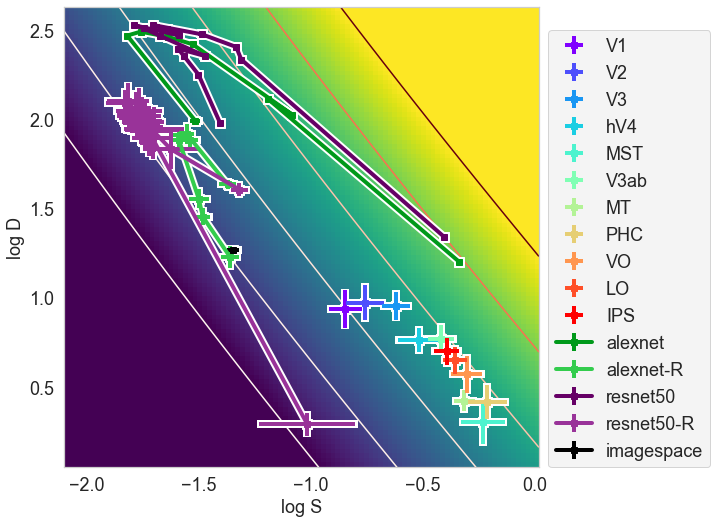

In [58]:
fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.75, top=.95, wspace=0.3, hspace=0.3)
gXmin, gXmax = np.inf, -np.inf
gYmin, gYmax = np.inf, -np.inf
all_N, all_Np = [],[]
for j,(name,traj) in enumerate(traj_dicts.items()):
    x_avg, y_avg = [], []
    for k in np.arange(traj.shape[2]):
        X = traj[np.argmax(np.array(space)=='Sign'),:,k,:]
        Y = traj[np.argmax(np.array(space)=='DR'),:,k,:]
        x_avg += [log10_transform_mean(X, axis=1),]
        y_avg += [log10_transform_mean(Y, axis=1),]
        
    X, Y = x_avg, y_avg = np.array(x_avg), np.array(y_avg)
    gXmin = np.min(X) if np.min(X)<gXmin else gXmin
    gXmax = np.max(X) if np.max(X)>gXmax else gXmax
    gYmin = np.min(Y) if np.min(Y)<gYmin else gYmin
    gYmax = np.max(Y) if np.max(Y)>gYmax else gYmax
    
    xa = log10_transform_mean(x_avg, axis=0)
    ya = log10_transform_mean(y_avg, axis=0)   
    xs = np.std(x_avg, axis=0)
    ys = np.std(y_avg, axis=0)
    if name=='nsdpred' or name=='nsddata':
        for k,(x,y,x_,y_,t) in enumerate(zip(xa, ya, xs, ys, plot_roi)):
            _=plt.errorbar(x, xerr=x_+.01, y=y, yerr=y_+.01, linestyle='None', marker='s', ms=10, color='w', lw=8, zorder=3)
            _=plt.errorbar(x, xerr=x_, y=y, yerr=y_, linestyle='None', marker='s', ms=6, color=roi_cmap[t], lw=4, label=t, zorder=900)
    else:
        _=plt.errorbar(xa, xerr=xs+.01, y=ya, yerr=ys+.01, marker='s', ms=10, color='w', lw=8, zorder=3)  
        _=plt.errorbar(xa, xerr=xs, y=ya, yerr=ys, marker='s', ms=6, color=model_cmap[name], lw=4, label=name, zorder=900) 
    ##
    X = np.array([traj[np.argmax(np.array(space)=='Sign'),:].flatten(), traj[np.argmax(np.array(space)=='DR'),:].flatten()])
    all_N += [traj[np.argmax(np.array(space)=='N')].flatten(),]
    all_Np+= [logN_fn_logS_and_logD(X, *global_popt),]
###
Xr, Yr = np.meshgrid(np.linspace(gXmin-.1, gXmax+.1, 100), np.linspace(gYmin-.1, gYmax+.1, 100))
Zr = SNR_fn_logS_and_logD_restricted(Xr, Yr, global_popt)
plt.imshow(SNR_norm(Zr), cmap='viridis', origin='lower', vmin=SNR_norm(.125/2), vmax=SNR_norm(2), extent=[gXmin-.1, gXmax+.1, gYmin-.1, gYmax+.1], zorder=1)
plt.contour(Xr, Yr, Zr, levels=[0.125/2, 0.125, .25, .5, 1., 2], cmap='Reds', zorder=2)  
###
_=plt.gca().set_aspect('auto')
_=plt.xlabel('log S')
_=plt.ylabel('log D')
_=plt.xlim([gXmin-.1, gXmax+.1])
_=plt.ylim([gYmin-.1, gYmax+.1])
_=plt.legend(loc=(1.02, 0), fontsize=18)

In [112]:
filename = output_dir + "nsdpred_vs_network_geom_traj_D_vs_S_v2%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

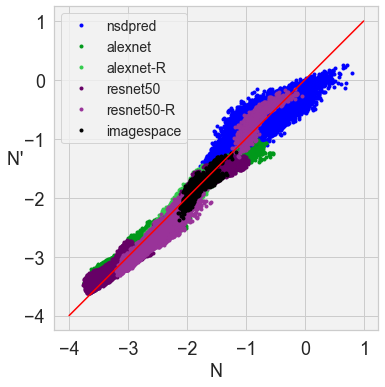

In [59]:
fig=plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.2, bottom=0.2, right=.95, top=.95, wspace=0.65, hspace=0.3)
for j,(Y, Yp, name) in enumerate(zip(all_N, all_Np, traj_dicts.keys())):
    _=plt.plot(Y, Yp, linestyle='None', marker='.', color=model_cmap[name], label=name)
_=plt.plot([-4,1], [-4,1], color='r')
_=plt.xlabel('N')
_=plt.ylabel('N\'  ', rotation=0)
_=plt.legend(loc='upper left', fontsize=14)

In [503]:
filename = output_dir + "joint_S_and_D_predict_N%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

# SNR joint predictivity

In [64]:
X = all_traj[np.argmax(np.array(space)=='Sign')]
Y = all_traj[np.argmax(np.array(space)=='DR')]
Z = all_SNR

Zr = SNR_fn_logS_and_logD_restricted(X, Y, global_popt)
print ('SNR map R2 = %.02f'%np.corrcoef(Z, Zr)[0,1]**2)

SNR map R2 = 0.57


In [72]:
for m, SNR, traj in zip_dict(SNR_dicts, traj_dicts):
    X = traj[np.argmax(np.array(space)=='Sign')].flatten()
    Y = traj[np.argmax(np.array(space)=='DR')].flatten()
    Z = SNR.flatten()

    Zr = SNR_fn_logS_and_logD_restricted(X, Y, global_popt)
    print ('SNR map R2 (%s) = %.02f' % (m, np.corrcoef(Z, Zr)[0,1]**2))

SNR map R2 (nsdpred) = 0.90
SNR map R2 (alexnet) = 0.43
SNR map R2 (alexnet-R) = 0.55
SNR map R2 (resnet50) = 0.52
SNR map R2 (resnet50-R) = 0.24
SNR map R2 (imagespace) = 0.75


## ROI labelling

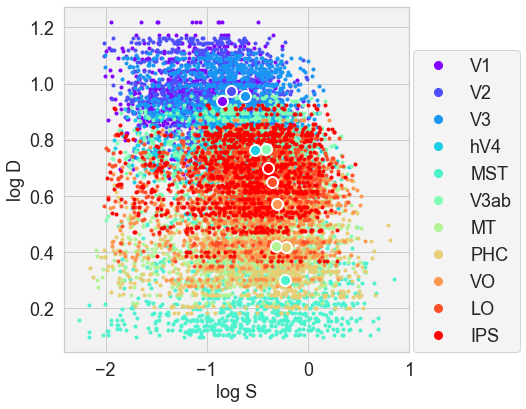

In [63]:
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3)
X = nsdpred_geom_traj[np.argmax(np.array(space)=='Sign'),:].reshape((nsdpred_geom_traj.shape[1], -1))
Y = nsdpred_geom_traj[np.argmax(np.array(space)=='DR'),:].reshape((nsdpred_geom_traj.shape[1], -1))

for k,(x,y,t) in enumerate(zip(X, Y, plot_roi)):
    plt.plot(x, y, linestyle='None', color=roi_cmap[t], alpha=1., marker='.')
    plt.plot(log10_transform_mean(x), log10_transform_mean(y), marker='o', color='w', ms=12,zorder=999)
    plt.plot(log10_transform_mean(x), log10_transform_mean(y), marker='o', linestyle='None', color=roi_cmap[t], ms=8, zorder=1000, label=t)
_=plt.xlabel('log S')
_=plt.ylabel('log D')
_=plt.legend(loc=(1.01, 0))

## Brain prediction empirical correlations
While the theory specify how the Signal, Dimensionality, Noise and other relate to the overall SNR, the observed correlations between these measures imply a different relation between SNR and these quantities, similar to the difference between partial derivative and total derivative


In [429]:
print (nsdpred_geom_dict['1'].keys())

dict_keys(['Bias', 'Ds', 'Nsa', 'Nsb', 'Nss', 'SNR', 'Sign', 'N', 'DR', 'DL', 'DRinv', 'DLinv'])


## Correlation of concept geometry across all ROIs

In [538]:
space = ['Sign', 'N', 'Bias', 'DR'] # 'Nsa', 'Nsb', 'Nss',

SNR_traj, geom_traj = get_geometric_space_array(nsdpred_geom_dict, subjects, plot_roi, space, lambda x: x, mask=None)

metric_average = {}
metric_average['SNR'] = SNR_traj.flatten() #np.mean(SNR_traj, axis=-1).flatten()
for k,s in enumerate(space):
    metric_average[s] = geom_traj[k].flatten() #np.mean(geom_traj[k], axis=-1).flatten()

In [539]:
n_shuffles = 1000

print ('Observed correlation')
metric_names = ['SNR',]+space
metric_corr = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
for i,iname in enumerate(metric_names):
    for j,jname in enumerate(metric_names):
        if j>i:
            metric_corr[i,j] = np.corrcoef(metric_average[iname].flatten(), metric_average[jname].flatten())[0,1]
            metric_corr[j,i] = metric_corr[i,j]
            
print ('\nRandomization test')
metric_names =  ['SNR',]+space
metric_null_mean = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
metric_null_std  = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
metric_null_pval = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
for i,iname in enumerate(metric_names):
    values = np.copy(metric_average[iname].flatten())
    for j,jname in enumerate(metric_names):
        if j>i:
            null = []
            for _ in range(n_shuffles):
                np.random.shuffle(values)
                null += [ np.corrcoef(values, metric_average[jname].flatten())[0,1], ]
            null = np.array(null)
            ##
            metric_null_mean[i,j] = np.mean(null)
            metric_null_mean[j,i] = metric_null_mean[i,j]
            
            metric_null_std[i,j] = np.std(null)
            metric_null_std[j,i] = metric_null_std[i,j]
                 
            metric_null_pval[i,j] = np.mean((np.abs(null)>np.abs(metric_corr[i,j])).astype(np.float32)) # fraction of null correlation more extreme than observed correlation
            metric_null_pval[j,i] = metric_null_pval[i,j]

Observed correlation

Randomization test


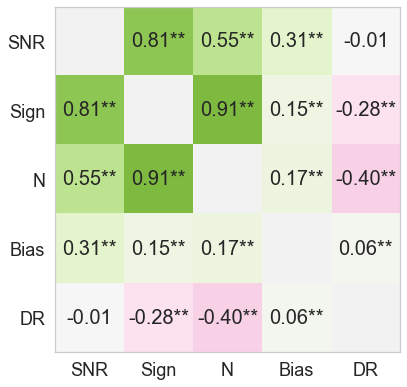

In [540]:
fig=plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3)
plt.imshow(metric_corr, cmap='PiYG', vmin=-1.5, vmax=1.5)
plt.grid(False)
ax=plt.gca()
_=ax.set_xticks(np.arange(len(metric_names)))
_=ax.set_xticklabels(metric_names)
_=ax.set_yticks(np.arange(len(metric_names)))
_=ax.set_yticklabels(metric_names)

for j,(pv, cv) in enumerate(zip(metric_null_pval, metric_corr)):
    for i,(p,c) in enumerate(zip(pv, cv)):
        if i!=j and p<0.001:
            _=plt.text(x=i, y=j, s='%.2f**'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')
        elif i!=j and p<0.05:
            _=plt.text(x=i, y=j, s='%.2f*'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')
        elif i!=j:
            _=plt.text(x=i, y=j, s='%.2f'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')

In [541]:
filename = output_dir + "gnetpred_SNR_component_correlations%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

## Correlation of Geometric ROI averages

In [542]:
space = ['Sign', 'N', 'Bias', 'DR'] # 'Nsa', 'Nsb', 'Nss',

SNR_traj, geom_traj = get_geometric_space_array(nsdpred_geom_dict, subjects, plot_roi, space, lambda x: x, mask=None)

metric_average = {}
metric_average['SNR'] = np.mean(SNR_traj, axis=-1).flatten()
for k,s in enumerate(space):
    metric_average[s] = np.mean(geom_traj[k], axis=-1).flatten()

In [543]:
n_shuffles = 1000

print ('Observed correlation')
metric_names = ['SNR',]+space
metric_corr = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
for i,iname in enumerate(metric_names):
    for j,jname in enumerate(metric_names):
        if j>i:
            metric_corr[i,j] = np.corrcoef(metric_average[iname].flatten(), metric_average[jname].flatten())[0,1]
            metric_corr[j,i] = metric_corr[i,j]
            
print ('\nRandomization test')
metric_names =  ['SNR',]+space
metric_null_mean = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
metric_null_std  = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
metric_null_pval = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
for i,iname in enumerate(metric_names):
    values = np.copy(metric_average[iname].flatten())
    for j,jname in enumerate(metric_names):
        if j>i:
            null = []
            for _ in range(n_shuffles):
                np.random.shuffle(values)
                null += [ np.corrcoef(values, metric_average[jname].flatten())[0,1], ]
            null = np.array(null)
            ##
            metric_null_mean[i,j] = np.mean(null)
            metric_null_mean[j,i] = metric_null_mean[i,j]
            
            metric_null_std[i,j] = np.std(null)
            metric_null_std[j,i] = metric_null_std[i,j]
                 
            metric_null_pval[i,j] = np.mean((np.abs(null)>np.abs(metric_corr[i,j])).astype(np.float32)) # fraction of null correlation more extreme than observed correlation
            metric_null_pval[j,i] = metric_null_pval[i,j]

Observed correlation

Randomization test


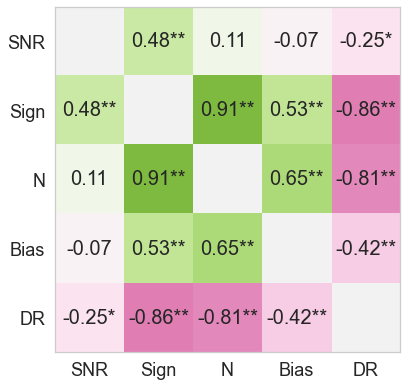

In [544]:
fig=plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3)
plt.imshow(metric_corr, cmap='PiYG', vmin=-1.5, vmax=1.5)
plt.grid(False)
ax=plt.gca()
_=ax.set_xticks(np.arange(len(metric_names)))
_=ax.set_xticklabels(metric_names)
_=ax.set_yticks(np.arange(len(metric_names)))
_=ax.set_yticklabels(metric_names)

for j,(pv, cv) in enumerate(zip(metric_null_pval, metric_corr)):
    for i,(p,c) in enumerate(zip(pv, cv)):
        if i!=j and p<0.001:
            _=plt.text(x=i, y=j, s='%.2f**'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')
        elif i!=j and p<0.05:
            _=plt.text(x=i, y=j, s='%.2f*'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')
        elif i!=j:
            _=plt.text(x=i, y=j, s='%.2f'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')

In [545]:
filename = output_dir + "gnetpred_SNR_component_correlations_average%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

## Network emprical correlation

In [546]:
frac  = 1.

SNR_traj_1, geom_traj_1 = get_geometric_space_array(alexnet_geom_dict, ssamples, \
    ['%d'%l for l in range(int(np.floor(frac*len(alexnet_geom_dict['1']['SNR']))))], space, lambda x: x, mask=None)
SNR_traj_2, geom_traj_2 = get_geometric_space_array(resnet50_geom_dict, ssamples, \
    ['%d'%l for l in range(int(np.floor(frac*len(resnet50_geom_dict['1']['SNR']))))], space, lambda x: x, mask=None)

SNR_traj  = np.concatenate([SNR_traj_1, SNR_traj_2], axis=0)
geom_traj = np.concatenate([geom_traj_1, geom_traj_2], axis=1)

metric_average = {}
#metric_average['SNR'] = np.mean(SNR_traj, axis=-1).flatten()
metric_average['SNR'] = SNR_traj.flatten() #np.mean(SNR_traj, axis=-1).flatten()
for k,s in enumerate(space):
    #metric_average[s] = np.mean(geom_traj[k], axis=-1).flatten()
    metric_average[s] = geom_traj[k].flatten() #np.mean(geom_traj[k], axis=-1).flatten()

In [547]:
n_shuffles = 1000

print ('Observed correlation')
metric_names = ['SNR',]+space
metric_corr = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
for i,iname in enumerate(metric_names):
    for j,jname in enumerate(metric_names):
        if j>i:
            metric_corr[i,j] = np.corrcoef(metric_average[iname].flatten(), metric_average[jname].flatten())[0,1]
            metric_corr[j,i] = metric_corr[i,j]
            
print ('\nRandomization test')
metric_names = ['SNR',]+space
metric_null_mean = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
metric_null_std  = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
metric_null_pval = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
for i,iname in enumerate(metric_names):
    values = np.copy(metric_average[iname].flatten())
    for j,jname in enumerate(metric_names):
        if j>i:
            null = []
            for _ in range(n_shuffles):
                np.random.shuffle(values)
                null += [ np.corrcoef(values, metric_average[jname].flatten())[0,1], ]
            null = np.array(null)     
            metric_null_mean[i,j] = np.mean(null)
            metric_null_mean[j,i] = metric_null_mean[i,j]
            
            metric_null_std[i,j] = np.std(null)
            metric_null_std[j,i] = metric_null_std[i,j]
                        
            metric_null_pval[i,j] = np.mean((np.abs(null)>np.abs(metric_corr[i,j])).astype(np.float32)) # fraction of null correlation more extreme than observed correlation
            metric_null_pval[j,i] = metric_null_pval[i,j]

Observed correlation

Randomization test


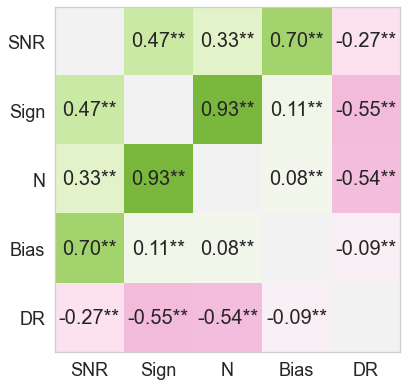

In [548]:
fig=plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3)
plt.imshow(metric_corr, cmap='PiYG', vmin=-1.5, vmax=1.5)
plt.grid(False)
ax=plt.gca()
_=ax.set_xticks(np.arange(len(metric_names)))
_=ax.set_xticklabels(metric_names)
_=ax.set_yticks(np.arange(len(metric_names)))
_=ax.set_yticklabels(metric_names)

for j,(pv, cv) in enumerate(zip(metric_null_pval, metric_corr)):
    for i,(p,c) in enumerate(zip(pv, cv)):
        if i!=j and p<0.001:
            _=plt.text(x=i, y=j, s='%.2f**'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')
        elif i!=j and p<0.05:
            _=plt.text(x=i, y=j, s='%.2f*'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')
        elif i!=j:
            _=plt.text(x=i, y=j, s='%.2f'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')

In [549]:
filename = output_dir + "networks_SNR_component_correlations%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

8it [00:07,  1.00it/s]


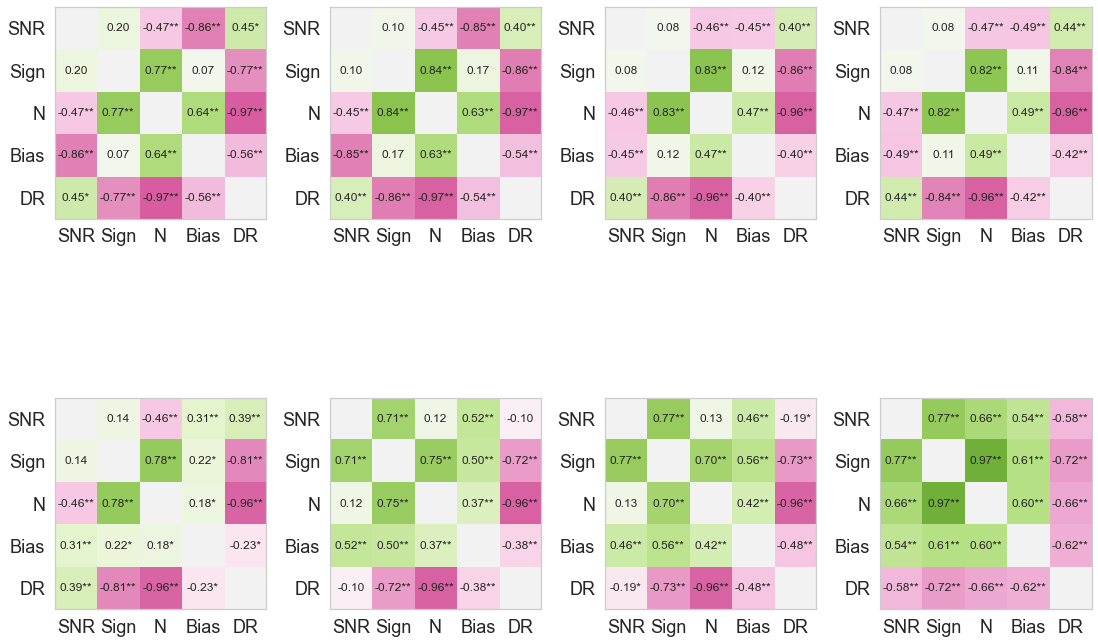

In [533]:
n_shuffles = 1000
fractions = [.3, .4, .5, .6, .7, .8, .9, 1.]
nx = 4
ny  = int(np.ceil(len(fractions)/nx))
fig=plt.figure(figsize=(6*nx, 6*ny))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3)
for l,f in tqdm(enumerate(fractions)):
          
    SNR_traj_1, geom_traj_1 = get_geometric_space_array(alexnet_geom_dict, ssamples, \
        ['%d'%l for l in range(int(np.floor(f*len(alexnet_geom_dict['1']['SNR']))))], space, lambda x: x, mask=None)
    SNR_traj_2, geom_traj_2 = get_geometric_space_array(resnet50_geom_dict, ssamples, \
        ['%d'%l for l in range(int(np.floor(f*len(resnet50_geom_dict['1']['SNR']))))], space, lambda x: x, mask=None)

    SNR_traj  = np.concatenate([SNR_traj_1, SNR_traj_2], axis=0)
    geom_traj = np.concatenate([geom_traj_1, geom_traj_2], axis=1)

    metric_average = {}
    metric_average['SNR'] = np.mean(SNR_traj, axis=-1).flatten()
    #metric_average['SNR'] = SNR_traj.flatten() #np.mean(SNR_traj, axis=-1).flatten()
    for k,s in enumerate(space):
        metric_average[s] = np.mean(geom_traj[k], axis=-1).flatten()
        #metric_average[s] = geom_traj[k].flatten() #np.mean(geom_traj[k], axis=-1).flatten()
        
    metric_names = ['SNR',]+space
    metric_corr = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
    for i,iname in enumerate(metric_names):
        for j,jname in enumerate(metric_names):
            if j>i:
                metric_corr[i,j] = np.corrcoef(metric_average[iname].flatten(), metric_average[jname].flatten())[0,1]
                metric_corr[j,i] = metric_corr[i,j]

    metric_names = ['SNR',]+space
    metric_null_mean = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
    metric_null_std  = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
    metric_null_pval = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
    for i,iname in enumerate(metric_names):
        values = np.copy(metric_average[iname].flatten())
        for j,jname in enumerate(metric_names):
            if j>i:
                null = []
                for _ in range(n_shuffles):
                    np.random.shuffle(values)
                    null += [ np.corrcoef(values, metric_average[jname].flatten())[0,1], ]
                null = np.array(null)     
                metric_null_mean[i,j] = np.mean(null)
                metric_null_mean[j,i] = metric_null_mean[i,j]

                metric_null_std[i,j] = np.std(null)
                metric_null_std[j,i] = metric_null_std[i,j]

                metric_null_pval[i,j] = np.mean((np.abs(null)>np.abs(metric_corr[i,j])).astype(np.float32)) # fraction of null correlation more extreme than observed correlation
                metric_null_pval[j,i] = metric_null_pval[i,j]
                
    plt.subplot(ny, nx, l+1)
    plt.imshow(metric_corr, cmap='PiYG', vmin=-1.5, vmax=1.5)
    plt.grid(False)
    ax=plt.gca()
    _=ax.set_xticks(np.arange(len(metric_names)))
    _=ax.set_xticklabels(metric_names)
    _=ax.set_yticks(np.arange(len(metric_names)))
    _=ax.set_yticklabels(metric_names)

    for j,(pv, cv) in enumerate(zip(metric_null_pval, metric_corr)):
        for i,(p,c) in enumerate(zip(pv, cv)):
            if i!=j and p<0.001:
                _=plt.text(x=i, y=j, s='%.2f**'%c, fontsize=12, horizontalalignment='center', verticalalignment='center')
            elif i!=j and p<0.05:
                _=plt.text(x=i, y=j, s='%.2f*'%c, fontsize=12, horizontalalignment='center', verticalalignment='center')
            elif i!=j:
                _=plt.text(x=i, y=j, s='%.2f'%c, fontsize=12, horizontalalignment='center', verticalalignment='center')

## Random network emprical correlation

In [534]:
frac = 1.

SNR_traj_1, geom_traj_1 = get_geometric_space_array(ralexnet_geom_dict, ssamples, \
    ['%d'%l for l in range(int(np.floor(frac*len(ralexnet_geom_dict['1']['SNR']))))], space, lambda x: x, mask=None)
SNR_traj_2, geom_traj_2 = get_geometric_space_array(resnet50R_geom_dict, ssamples, \
    ['%d'%l for l in range(int(np.floor(frac*len(resnet50R_geom_dict['1']['SNR']))))], space, lambda x: x, mask=None)

SNR_traj  = np.concatenate([SNR_traj_1, SNR_traj_2], axis=0)
geom_traj = np.concatenate([geom_traj_1, geom_traj_2], axis=1)

metric_average = {}
metric_average['SNR'] = np.mean(SNR_traj, axis=-1).flatten()
#metric_average['SNR'] = SNR_traj.flatten() #np.mean(SNR_traj, axis=-1).flatten()
for k,s in enumerate(space):
    metric_average[s] = np.mean(geom_traj[k], axis=-1).flatten()
    #metric_average[s] = geom_traj[k].flatten() #np.mean(geom_traj[k], axis=-1).flatten()

In [535]:
n_shuffles = 100

print ('Observed correlation')
metric_names = ['SNR',]+space
metric_corr = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
for i,iname in enumerate(metric_names):
    for j,jname in enumerate(metric_names):
        if j>i:
            metric_corr[i,j] = np.corrcoef(metric_average[iname].flatten(), metric_average[jname].flatten())[0,1]
            metric_corr[j,i] = metric_corr[i,j]
            
print ('\nRandomization test')
metric_names = ['SNR',]+space
metric_null_mean = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
metric_null_std  = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
metric_null_pval = np.full(fill_value=np.nan, shape=(len(metric_names), len(metric_names)))
for i,iname in enumerate(metric_names):
    values = np.copy(metric_average[iname].flatten())
    for j,jname in enumerate(metric_names):
        if j>i:
            null = []
            for _ in range(n_shuffles):
                np.random.shuffle(values)
                null += [ np.corrcoef(values, metric_average[jname].flatten())[0,1], ]
            null = np.array(null)     
            metric_null_mean[i,j] = np.mean(null)
            metric_null_mean[j,i] = metric_null_mean[i,j]
            
            metric_null_std[i,j] = np.std(null)
            metric_null_std[j,i] = metric_null_std[i,j]
            
            metric_null_pval[i,j] = np.mean((np.abs(null)>np.abs(metric_corr[i,j])).astype(np.float32)) # fraction of null correlation more extreme than observed correlation
            metric_null_pval[j,i] = metric_null_pval[i,j]

Observed correlation

Randomization test


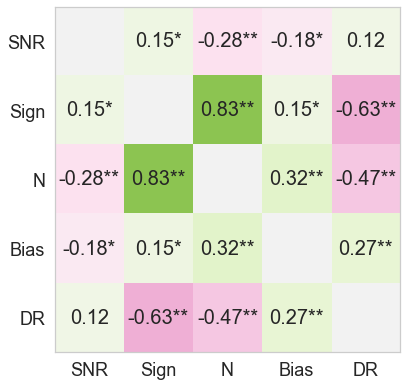

In [536]:
fig=plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.2, bottom=0.15, right=.8, top=.95, wspace=0.3, hspace=0.3)
plt.imshow(metric_corr, cmap='PiYG', vmin=-1.5, vmax=1.5)
plt.grid(False)
ax=plt.gca()
_=ax.set_xticks(np.arange(len(metric_names)))
_=ax.set_xticklabels(metric_names)
_=ax.set_yticks(np.arange(len(metric_names)))
_=ax.set_yticklabels(metric_names)

for j,(pv, cv) in enumerate(zip(metric_null_pval, metric_corr)):
    for i,(p,c) in enumerate(zip(pv, cv)):
        if i!=j and p<0.001:
            _=plt.text(x=i, y=j, s='%.2f**'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')
        elif i!=j and p<0.05:
            _=plt.text(x=i, y=j, s='%.2f*'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')
        elif i!=j:
            _=plt.text(x=i, y=j, s='%.2f'%c, fontsize=20, horizontalalignment='center', verticalalignment='center')

In [537]:
filename = output_dir + "networks_random_SNR_component_correlations_average%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()